In [5]:
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from pathlib import Path

import networkx as nx
import geonetworkx as gnx

from dask.distributed import Client

In [6]:
# client = Client(n_workers=4)
# client

In [7]:
PLOTTING_PROJ = ccrs.PlateCarree()
DIST_PROJ = "+proj=eqdc +lon_0=-103.7988281 +lat_1=35.7127609 +lat_2=43.8942567 +lat_0=39.8035088 +datum=WGS84 +units=m +no_defs"

def geoax(figsize=(10, 5), **kwargs):
    f, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": PLOTTING_PROJ}, **kwargs)
    ax.add_feature(cartopy.feature.BORDERS)
    
    return f, ax

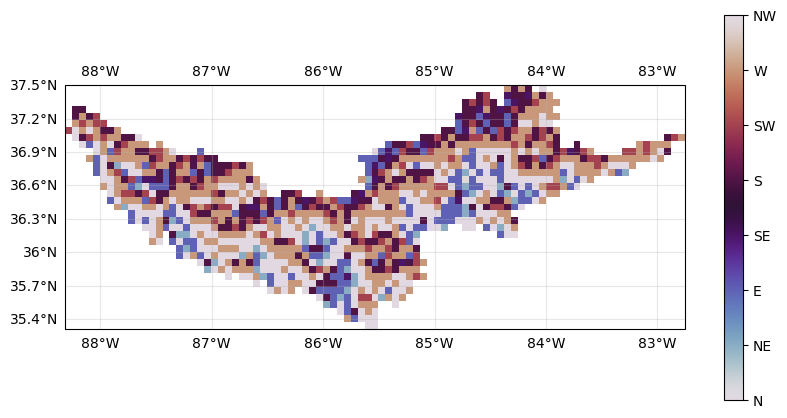

In [8]:
# read in the flow direction file
fdr = rxr.open_rasterio("../../data-cumberland/tennessee/basins/cumberland/ro/pars/fl.tif", masked=True)  # nodask
band = fdr.sel(band=1)

band_vicfmt = band  # it is already in vic-format, no need to reclassify

f, ax = geoax()
im = ax.imshow(band_vicfmt, extent=plotting_extent(band, fdr.rio.transform()), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

In [16]:
reservoirs_fn = "../../data-cumberland/cumberland-stations/cumberland-resops-stations.csv"
reservoirs = gpd.read_file(reservoirs_fn)
reservoirs['geometry'] = gpd.points_from_xy(reservoirs['lon'], reservoirs['lat'])
reservoirs.set_crs('epsg:4326', inplace=True)

reservoirs.head()

,run,name,lat,lon,geometry
0,0,Barkley_Dam,37.018747,-88.218748,POINT (-88.21875 37.01875)
1,1,Laurel_Dam,36.959995,-84.267474,POINT (-84.26747 36.95999)
2,1,Wolf_Creek,36.867817,-85.14375,POINT (-85.14375 36.86782)
3,1,Dale_Hollow_Dam,36.538312,-85.450254,POINT (-85.45025 36.53831)
4,1,Old_Hickory_Dam,36.29189,-86.658869,POINT (-86.65887 36.29189)


In [17]:
reservoirs.iloc[0]

run                                    0
name                         Barkley_Dam
lat                            37.018747
lon                           -88.218748
geometry    POINT (-88.218748 37.018747)
Name: 0, dtype: object

In [18]:
# # create a raster where the pixel values specify the index of reservoirs
# sampled_xy = [xy for xy in zip(reservoirs['lon'], reservoirs['lat'])]

reservoir_location_raster = xr.full_like(band_vicfmt, np.nan)
for resid, row in reservoirs.iterrows():
    reslat = float(row.lat)
    reslon = float(row.lon)

    rast_lat = reservoir_location_raster.indexes['y'].get_indexer([reslat], method="nearest")[0]
    rast_lon = reservoir_location_raster.indexes['x'].get_indexer([reslon], method="nearest")[0]

    reservoir_location_raster[rast_lat, rast_lon] = resid

In [19]:
# type(reservoirs['geometry'])

In [20]:
# convert all points to nodes. Use index value to identify
G = nx.DiGraph()
G.add_nodes_from(reservoirs.index)

operations = {
    1: [-1, 0],  # N
    2: [-1, 1],  # NE
    3: [0, 1],   # E
    4: [1, 1],   # SE
    5: [1, 0],   # S
    6: [1, -1],  # SW
    7: [0, -1],  # W
    8: [-1, -1], # NW
}

for node in G.nodes:
    resdata = reservoirs[reservoirs.index==node]
    
    x = float(resdata['lon'].values[0])
    y = float(resdata['lat'].values[0])

    idxx = band_vicfmt.indexes['x'].get_indexer([x], method="nearest")[0]
    idxy = band_vicfmt.indexes['y'].get_indexer([y], method="nearest")[0]
    
    # travel downstream until another node, np.nan or out-of-bounds is found, or if travelling in a loop

    visited = [(idxx, idxy)]
    current_pix = band_vicfmt.isel(x=idxx, y=idxy)

    attrs_n = {
        node: {
            'x': reservoirs['geometry'][node].x,
            'y': reservoirs['geometry'][node].y,
            'name': reservoirs['name'][node]
        }
    }
    nx.set_node_attributes(G, attrs_n)

    END = False
    while not END:
        op = operations[int(current_pix)]
        new_idxy, new_idxx = np.array((idxy, idxx)) + np.array(op)
        idxy, idxx = new_idxy, new_idxx
        
        if (new_idxx, new_idxy) in visited:
            # In a loop, exit
            END=True
            break
        else:
            visited.append((new_idxx, new_idxy))

        current_pix = band_vicfmt.isel(x=new_idxx, y=new_idxy)
        if np.isnan(current_pix):
            # NaN value found, exit loop
            END=True
            break

        try:
            any_reservoir = reservoir_location_raster.isel(x=new_idxx, y=new_idxy)
            if not np.isnan(any_reservoir):
                # another reservoir found
                G.add_edge(node, int(any_reservoir))
                attrs_e = {
                    (node, int(any_reservoir)): {
                        'length': reservoirs.to_crs(DIST_PROJ)['geometry'][node].distance(reservoirs.to_crs(DIST_PROJ)['geometry'][int(any_reservoir)])
                    }
                }
                nx.set_edge_attributes(G, attrs_e)
                END = True
                break
        except IndexError:
            print(f"Reached end")
            END=True

In [21]:
G

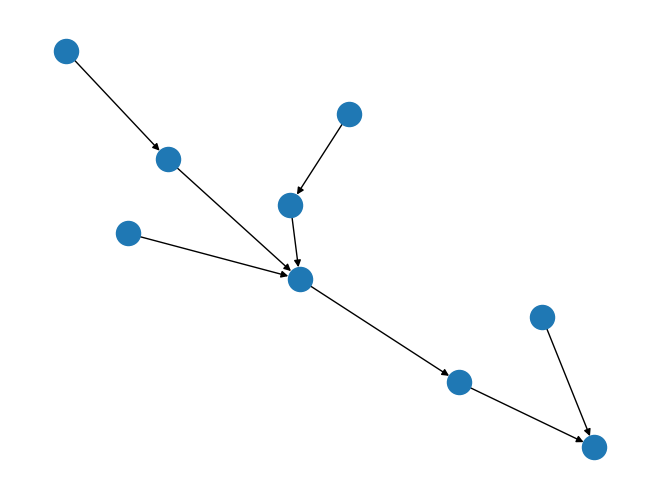

In [22]:
nx.draw(G)

In [28]:
save_dir = Path("../../data-cumberland/cumberland_rivreg/")
save_dir.mkdir(exist_ok=True)

G_gdf = gpd.GeoDataFrame(gnx.graph_edges_to_gdf(G))
G_gdf_pts = gpd.GeoDataFrame(gnx.graph_nodes_to_gdf(G))  # returns a pd.DF instead of gpd.GDF, although it has a geometry column

In [29]:
# add elevation data to nodes
elevation_fn = Path("../../global_data/global_elevation_data/World_e-Atlas-UCSD_SRTM30-plus_v8.tif")
elev = rxr.open_rasterio(elevation_fn, chunks='auto')

G_gdf_pts['elevation'] = G_gdf_pts[['x', 'y']].apply(lambda row: float(elev.sel(x=row.x, y=row.y, method='nearest')), axis=1)
G_gdf_pts.head()

,x,y,name,id,geometry,elevation
0,-88.218748,37.018747,Barkley_Dam,0,POINT (-88.21875 37.01875),106.0
1,-84.267474,36.959995,Laurel_Dam,1,POINT (-84.26747 36.95999),301.0
2,-85.14375,36.867817,Wolf_Creek,2,POINT (-85.14375 36.86782),196.0
3,-85.450254,36.538312,Dale_Hollow_Dam,3,POINT (-85.45025 36.53831),195.0
4,-86.658869,36.29189,Old_Hickory_Dam,4,POINT (-86.65887 36.29189),131.0


In [30]:
def slope_calculator(u, v, length, pts_gdf):
    return np.abs(pts_gdf.loc[u]['elevation'] - pts_gdf.loc[v]['elevation'])/length

# calculate slope
G_gdf['slope'] = G_gdf.apply(lambda row: slope_calculator(row.u, row.v, row.length, G_gdf_pts), axis=1)
G_gdf.head()

,u,v,length,geometry,slope
0,1,2,78657.642529,"LINESTRING (-84.26747 36.95999, -85.14375 36.8...",0.001335
1,2,8,95924.360233,"LINESTRING (-85.14375 36.86782, -85.94413 36.2...",0.000396
2,3,8,52007.174539,"LINESTRING (-85.45025 36.53831, -85.94413 36.2...",0.000711
3,4,0,160991.672727,"LINESTRING (-86.65887 36.29189, -88.21875 37.0...",0.000155
4,5,0,172229.595787,"LINESTRING (-86.61800 36.15526, -88.21875 37.0...",0.000244


,u,v,length,geometry,slope,R,n,velocity,travel_time
0,1,2,78657.642529,"LINESTRING (-84.26747 36.95999, -85.14375 36.8...",0.001335,3.333333,0.01,8.152861,0.111665
1,2,8,95924.360233,"LINESTRING (-85.14375 36.86782, -85.94413 36.2...",0.000396,3.333333,0.01,4.441331,0.249978
2,3,8,52007.174539,"LINESTRING (-85.45025 36.53831, -85.94413 36.2...",0.000711,3.333333,0.01,5.951892,0.101133
3,4,0,160991.672727,"LINESTRING (-86.65887 36.29189, -88.21875 37.0...",0.000155,3.333333,0.01,2.780700,0.670094
4,5,0,172229.595787,"LINESTRING (-86.61800 36.15526, -88.21875 37.0...",0.000244,3.333333,0.01,3.484629,0.572055


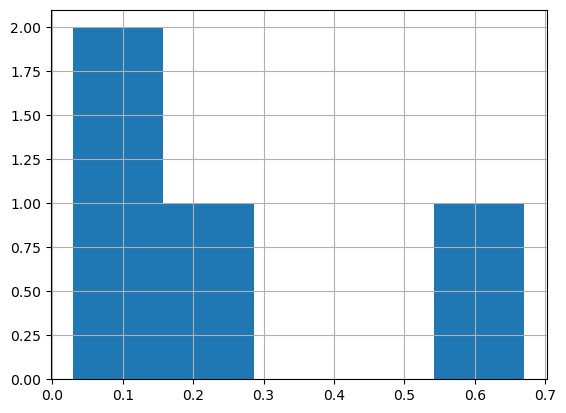

In [31]:
# assume manning's n
n = 0.01

# assume hydraulic radius R for now - change it later to parameterize it
A = 20*5    # rectangular stream, b=20, h=5
P = 20+5+5
G_gdf['R'] = A/P    # m

G_gdf['n'] = n
G_gdf['velocity'] = (1/G_gdf['n']) * G_gdf['R'].pow(2/3) * G_gdf['slope'].pow(1/2)  # m/s

G_gdf['travel_time'] = G_gdf['length'] / (G_gdf['velocity'] * (60*60*24))

G_gdf['travel_time'].hist()

G_gdf.head()

In [32]:
# save the files
G_gdf.to_file(save_dir / "cumberland_rivreg.shp")
G_gdf_pts.to_file(save_dir / "cumberland_rivreg_pts.shp")

# save the files
G_gdf.to_file(save_dir / "cumberland_rivreg.geojson")
G_gdf_pts.to_file(save_dir / "cumberland_rivreg_pts.geojson")

/tmp/ipykernel_1467298/2131786406.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  G_gdf.to_file(save_dir / "cumberland_rivreg.shp")
